In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.linalg import solve_sylvester, norm
import os
from sklearn.metrics import confusion_matrix, f1_score
import json
import pandas as pd

Data generation

In [3]:
def ensure_positive_definite(M, epsilon=1e-1, min_threshold=1e-3):
    """Ensure M is well-conditioned ; add small value to diagonal if needed"""
    min_eig = np.min(np.linalg.eigvals(M))
    
    if min_eig < min_threshold:
        print(f"Minimum eigenvalue too small ({min_eig:.2e}), adding {epsilon} to diagonal elements.")
        M += np.eye(M.shape[0]) * (abs(min_eig) + epsilon)
        
    min_eig = np.min(np.linalg.eigvals(M))
    print(f"Minimum eigen value after adding to diagonal: {min_eig:.2e}")
    return M

In [5]:
def make_d_diagonal_spd_matrix(
        n_dim=10,
        d=3, 
        smallest_coef=0.1,
        largest_coef=0.9,
        random_state=None
):
    """ 
    Generate a d-diagonal SPD matrix
    """

    # Ensure d is odd, otherwise raise an exception
    if d % 2 == 0:
        raise ValueError("d must be an odd number.")

    rng = np.random.default_rng(random_state)

    # Initialize diagonal
    diag = np.ones(n_dim)

    # Initialize matrix
    m = np.diag(diag)

    # Fill subdiagonal and superdiagonal values symmetrically
    half_bandwidth = (d - 1) // 2
    for w in range(1, half_bandwidth + 1):  # 1st, 2nd, ..., half_bandwidth diagonals
        for i in range(n_dim - w):
            temp = rng.uniform(low=smallest_coef, high=largest_coef)
            m[i + w, i] = temp
            m[i, i + w] = temp  # Maintain symmetry

    # Ensure positive definiteness
    return ensure_positive_definite(m)


Minimum eigenvalue too small (-5.73e-01), adding 0.1 to diagonal elements.
Minimum eigen value after adding to diagonal: 1.00e-01


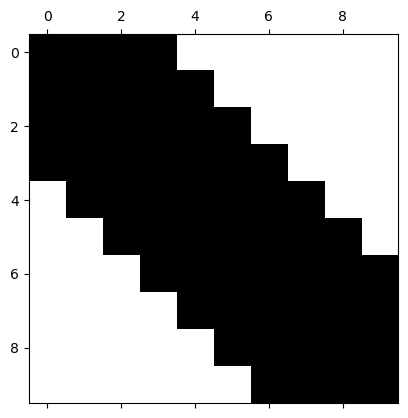

In [8]:
plt.spy(make_d_diagonal_spd_matrix(d=7)) # check if its giving 

In [9]:
def generate_sparse_covariance(B, sample_scaling=1.0):
    """
    Generate a sparse inverse covariance matrix B, compute its associated covariance matrix E,
    and generate samples from a multivariate normal distribution with covariance E.

    Parameters:
    - n (int): Dimension of the matrix.
    - sample_scaling (float): Scaling factor for the number of samples (N = sample_scaling * d^2 log2(n)).
    - random_state (int): Random seed for reproducibility.

    Returns:
    - S (np.ndarray): Sample covariance matrix from the generated samples.
    - N (int): Computed number of samples.
    """
    # Create sparse PSD matrix (B)
    # B = make_tridiagonal_spd_matrix(n_dim=n, random_state= random_state)
    n = len(B)

    # Compute degree d as the maximum number of nonzero entries per row in B (excluding diagonal)
    d = np.max(np.sum(B != 0, axis=1)) - 1  # Exclude diagonal elements
    print("Max degree in B", d)

    # Compute the required number of samples with log 
    N = int(sample_scaling * ((d*d) * np.log(n)))
    # N = max(N, n)  # Ensure N is at least n for stability

    # Compute true inverse covariance matrix (Strue)
    Strue = np.linalg.matrix_power(B, 2)

    # Compute covariance matrix (E)
    E = np.linalg.inv(Strue)

    # Generate N samples Y ~ N(0, E)
    y_samples = la.sqrtm(E).dot(np.random.randn(n, N))

    # Calculate sample covariance matrix
    S = np.cov(y_samples)

    return S, N

Minimum eigenvalue too small (-3.50e-01), adding 0.1 to diagonal elements.
Minimum eigen value after adding to diagonal: 1.00e-01
Max degree in B 2
Number of samples 46
F1 norm 43.38162369815833


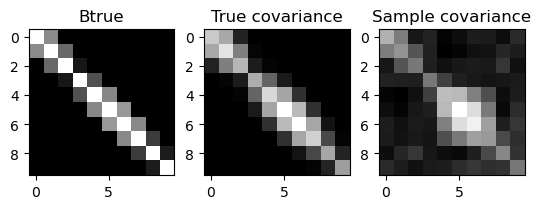

In [18]:
B = make_d_diagonal_spd_matrix()
S, N = generate_sparse_covariance(B, sample_scaling=5)
plt.subplot(1,3, 1)
plt.imshow(B, cmap = 'gray')
plt.title("Btrue")
plt.subplot(1,3,2)
plt.imshow(B@B, cmap = 'gray')
plt.title("True covariance")
plt.subplot(1,3,3)
plt.imshow(np.linalg.inv(S), cmap = 'gray')
plt.title("Sample covariance")
print("Number of samples", N)
print("F1 norm", np.linalg.norm(np.linalg.inv(B@B)-S, ord="fro"))

Algorithm

In [29]:
def newton_nare(A, B, C, D, X0, tol=1e-13, kmax=30):
    """
    Newton's method for solving the Nonlinear Algebraic Riccati Equation (NARE):
    C + XA + DX - XBX = 0
    """
    X = X0.copy()
    k = 0
    err = 1

    while err > tol and k < kmax:
        # Compute residual RX = C + XA + DX - XBX
        RX = C + X @ A + D @ X - X @ B @ X

        # Solve the Sylvester equation (D - XB)H + H(A - BX) = -RX for H
        H = solve_sylvester(D - X @ B, A - B @ X, -RX)

        # Update X
        X = X + H

        # Calculate the error; changed from l1 to frobenius
        err = norm(H, 1) / norm(X, 1)
        # err = norm(H, 'fro') / (1 + norm(X, 'fro'))

        if k % 5 == 0:  # Print every 5 iterations
            print(f"Iteration {k}, Error: {err:.2e}")
        
        # Increment iteration counter
        k += 1

    # Check if the solution converged
    if k == kmax:
        print("Warning: reached the maximum number of iterations without convergence.")

    return X

In [21]:
# Soft thresholding function
def soft_thresholding(x, threshold):
    """Applies soft-thresholding elementwise."""
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

In [40]:
def soft_thresholding_offdiag(B_new, Lambda, lambda_, rho):
    """
    Applies off-diagonal soft-thresholding.
    """
    
    # Compute argument for soft-thresholding
    X = rho * B_new + Lambda
    
    # Create a copy to modify
    Z_new = X.copy()
    
    # Off-diagonal mask
    mask_offdiag = ~np.eye(X.shape[0], dtype=bool)

    # Apply soft-thresholding only to off-diagonal elements
    Z_new[mask_offdiag] = np.sign(X[mask_offdiag]) * np.maximum(np.abs(X[mask_offdiag]) - lambda_, 0)

    return Z_new


In [39]:
# ADMM Algorithm for Elastic-Net Penalized Precision Matrix Estimation
def admm_precision_matrix(S, lambda_, rho=1.0, max_iter=100, tol=1e-4):
    """
    ADMM algorithm for precision matrix estimation with elastic-net penalty.
    """
    n = S.shape[0]
    Z = np.zeros((n, n))
    Lambda = np.zeros((n, n))
    I = np.eye(n)  # Identity matrix

    # Initial B (can be initialized as identity matrix)
    B = np.eye(n)

    for k in range(max_iter):
        # Step 1: Update B using Newton NARE
        # Here, we set up the matrices to solve the NARE: A3 + XA1 + A4X - XA2X = 0
        A3 = - 2 * I
        A4 = Lambda - rho * Z
        A1 = 0 * I
        A2 = - (2 * S + rho * I)
        X0 = B  # Initial guess for Newton NARE

        # Solve for the new B using Newton NARE
        B_new = newton_nare(A1, A2, A3, A4, X0)

        # Step 2: Update Z elementwise using soft-thresholding
        Z_new = soft_thresholding(rho * B_new + Lambda, lambda_)
        Z_new = Z_new / rho

        # Step 3: Update Lambda (Lagrange multiplier)
        Lambda_new = Lambda + rho * (B_new - Z_new)

        # print(f"ADMM update loss: ", np.linalg.norm(B_new - B, ord='fro') )
        # Check convergence
        if np.linalg.norm(B_new - B, ord='fro') < tol:
            print(f"ADMM Converged after {k+1} iterations.")
            break
        elif k == max_iter-1 :
            print(f"ADMM failed to converge after {k+1} iterations.")

        # Update for the next iteration
        B, Z, Lambda = B_new, Z_new, Lambda_new      

    return B

In [23]:
#Thresholding B_estimate
def hard_threshold(B_estimate,threshold):
  return np.where(np.abs(B_estimate) > threshold, B_estimate, 0)

Simple experiment

In [36]:
B = make_d_diagonal_spd_matrix(n_dim= 30, d=5)

Minimum eigenvalue too small (-7.00e-01), adding 0.1 to diagonal elements.
Minimum eigen value after adding to diagonal: 1.00e-01


In [45]:
S, N = generate_sparse_covariance(B, sample_scaling=1.0)
# Parameters for the elastic-net penalty and ADMM algorithm
lambda_ = 0.166  # Regularization strength
alpha = 1  # Mixing parameter (0 = Ridge, 1 = Lasso)
rho = 1.0  # ADMM penalty parameter
max_iter = 200  # Maximum number of iterations
tol = 1e-4  # Convergence tolerance

# Run the ADMM algorithm using the generated sample covariance matrix
B_estimate = admm_precision_matrix(S, lambda_, rho, max_iter, tol)

print("Estimated Precision Matrix (B estimate):")
print(B_estimate)

Max degree in B 4
Iteration 0, Error: 5.69e-01
Iteration 5, Error: 3.11e-04
Iteration 0, Error: 1.85e-01
Iteration 0, Error: 2.79e-01
Iteration 5, Error: 3.22e-15
Iteration 0, Error: 1.61e-01
Iteration 0, Error: 1.06e-01
Iteration 0, Error: 6.74e-02
Iteration 0, Error: 4.91e-02
Iteration 0, Error: 3.41e-02
Iteration 0, Error: 2.43e-02
Iteration 0, Error: 1.84e-02
Iteration 0, Error: 1.34e-02
Iteration 0, Error: 9.20e-03
Iteration 0, Error: 6.04e-03
Iteration 0, Error: 4.09e-03
Iteration 0, Error: 3.43e-03
Iteration 0, Error: 2.88e-03
Iteration 0, Error: 2.39e-03
Iteration 0, Error: 2.13e-03
Iteration 0, Error: 1.77e-03
Iteration 0, Error: 1.54e-03
Iteration 0, Error: 1.33e-03
Iteration 0, Error: 1.15e-03
Iteration 0, Error: 1.01e-03
Iteration 0, Error: 8.86e-04
Iteration 0, Error: 7.84e-04
Iteration 0, Error: 6.99e-04
Iteration 0, Error: 6.28e-04
Iteration 0, Error: 5.74e-04
Iteration 0, Error: 7.14e-04
Iteration 0, Error: 5.29e-04
Iteration 0, Error: 4.54e-04
Iteration 0, Error: 4.00e

Text(0.5, 1.0, 'B estimate - 1e-2 tres')

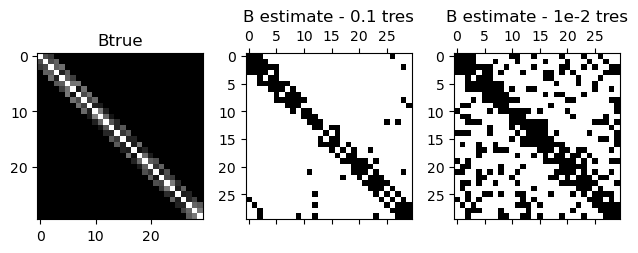

In [46]:
plt.subplot(1,3, 1)
plt.imshow(B, cmap= "gray")
plt.title("Btrue")
plt.subplot(1,3,2)
# plt.imshow(hard_threshold(B_estimate, 0.2), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 0.1))
plt.title("B estimate - 0.1 tres")
plt.subplot(1,3,3)
# plt.imshow(hard_threshold(B_estimate, 0.4), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 1e-2))
plt.tight_layout()
plt.title("B estimate - 1e-2 tres")

Experimentation

In [47]:
def evaluate_edge_recovery_vs_lambda(lambda_values, B, sample_scaling=1.0,
                                     rho=1.0, max_iter=100, tol=1e-4,
                                     threshold=1e-4, log_dir="experiment_logs"):
    """
    Evaluate edge_recovery_rate = TP / (total edges in B), 
    excluding diagonal elements, for each lambda.
    """
    
    B = np.array(B)
    n = B.shape[0]
    
    # generate sample covariance S and sample size N
    S, N = generate_sparse_covariance(B, sample_scaling=sample_scaling)

    print("Number of samples:", N)
    print("Minimum eigenvalue of B:", np.min(np.linalg.eigvals(B)))

    # Ground-truth adjacency (full)
    ground_truth_adjacency = (B != 0).astype(int)

    # Exclude diagonals via a mask
    mask_offdiag = ~np.eye(n, dtype=bool)

    # Count how many edges (off-diagonal) are in B
    total_offdiag_edges_in_B = np.count_nonzero(ground_truth_adjacency[mask_offdiag])

    metrics = {
        "lambda": [],
        "edge_recovery_rate": [],
        "plot_paths": []
    }

    for lambda_ in lambda_values:
        # Estimate precision matrix with user-defined ADMM function
        B_est = admm_precision_matrix(S, lambda_, rho, max_iter, tol)

        # Threshold the estimate
        B_est_thresholded = hard_threshold(B_est, threshold)

        # Plot and save the sparsity patterns (optional, can remove if not needed)
        plt.figure(figsize=(6, 12))
        
        plt.subplot(1, 2, 1)
        plt.spy(B)
        plt.title("B (True)", fontsize=16)

        plt.subplot(1, 2, 2)
        plt.spy(B_est_thresholded)
        plt.title("B_est (Estimated)", fontsize=16)

        plot_path = os.path.join(log_dir, f"sparsity_lambda_{lambda_:.3f}.png")
        plt.savefig(plot_path)
        plt.close()
        
        # Compute the number of True Positives (TP) off-diagonal
        #   TP = number of off-diagonal entries where B != 0 AND B_est != 0
        predicted_adjacency = (B_est_thresholded != 0).astype(int)
        gt_offdiag = ground_truth_adjacency[mask_offdiag]
        pred_offdiag = predicted_adjacency[mask_offdiag]

        TP = np.count_nonzero((gt_offdiag == 1) & (pred_offdiag == 1))

        # Edge recovery rate = TP / (total edges in B off-diagonal)
        # (Protect against division by zero if B has no edges)
        if total_offdiag_edges_in_B == 0:
            edge_recovery_rate = 0.0
        else:
            edge_recovery_rate = TP / total_offdiag_edges_in_B

        # Store the results
        metrics["lambda"].append(lambda_)
        metrics["edge_recovery_rate"].append(edge_recovery_rate)
        metrics["plot_paths"].append(plot_path)

    return metrics

In [74]:
# Updated main loop
n = 30
sample_scaling = 1.0
d = 7
B = make_d_diagonal_spd_matrix(n_dim= n, d = d)

log_dir = f"experiment_logs/n_{n}_scale_{sample_scaling}_d{d}"
# Create a directory to save logs if it doesn’t exist
os.makedirs(log_dir, exist_ok=True)

# params
args = {
    "lambda_values": np.linspace(0.1,0.3, 30).tolist(),
    "B": B.tolist(),
    "sample_scaling": sample_scaling,
    "rho": 2.0,
    "max_iter": 200,
    "tol": 1e-4,
    "threshold": 1e-2,
    "log_dir": log_dir
}
print(f"Evaluating metrics for {args}")

# Save args to a JSON file (for reproducibility)
json_path = os.path.join(log_dir, "params.json")
with open(json_path, "w") as json_file:
    json.dump(args, json_file, indent=4)

# Call our updated evaluate_metrics_vs_lambda
metrics = evaluate_edge_recovery_vs_lambda(**args)

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Save metrics to CSV or Excel
csv_path = os.path.join(log_dir, "metrics.csv")
metrics_df.to_csv(csv_path, index=False)

# Pick best lambda by F1
best_idx = metrics_df["edge_recovery_rate"].idxmax()
best_lambda = metrics_df.loc[best_idx, "lambda"]
print(f"Best lambda by edge_recovery_rate = {best_lambda:.3f}")

# Plot all metrics vs. lambda
plt.figure(figsize=(8, 6))
for metric in ["edge_recovery_rate"]:
    plt.plot(metrics_df["lambda"], metrics_df[metric], marker="o", label=metric)

plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Metric Value")
plt.title("Metrics vs. Lambda")
plt.legend()
plot_path = os.path.join(log_dir, "metrics_vs_lambda.png")
plt.savefig(plot_path)
plt.close()


Minimum eigenvalue too small (-8.31e-01), adding 0.1 to diagonal elements.
Minimum eigen value after adding to diagonal: 1.00e-01
Evaluating metrics for {'lambda_values': [0.1, 0.10689655172413794, 0.11379310344827587, 0.1206896551724138, 0.12758620689655173, 0.13448275862068965, 0.1413793103448276, 0.1482758620689655, 0.15517241379310345, 0.16206896551724137, 0.16896551724137931, 0.17586206896551723, 0.18275862068965515, 0.1896551724137931, 0.19655172413793104, 0.20344827586206896, 0.21034482758620687, 0.21724137931034482, 0.22413793103448276, 0.23103448275862068, 0.2379310344827586, 0.24482758620689654, 0.25172413793103443, 0.2586206896551724, 0.2655172413793103, 0.27241379310344827, 0.2793103448275862, 0.28620689655172415, 0.29310344827586204, 0.3], 'B': [[1.9311906787994122, 0.5009230785283463, 0.7733065852201725, 0.5342388984611348, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5009230785283463

F1 vs sample scaling

In [81]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def plot_f1_vs_sample_scaling(
    B,
    best_lambda=0.1,
    d_values=[3, 5, 7, 9],
    rho=3.0,
    max_iter=500,
    tol=1e-4,
    threshold=2e-2,
    scaling_values=None,
    log_dir="experiment_scale_logs"
):
    """
    Fix parameters (n, alpha, best_lambda, etc.) and update sample_scaling from
    1..5 to see how F1 improves with more samples for different d values.
    """
    if scaling_values is None:
        scaling_values = np.arange(1, 21)
    
    
    os.makedirs(log_dir, exist_ok=True)
    n = 30
    
    plt.figure(figsize=(8, 6))
    
    results = []
    
    for d in d_values:
        f1_scores = []
        B = make_d_diagonal_spd_matrix(n_dim=30, d=d)
         # Ground-truth adjacency (full)
        ground_truth_adjacency = (B != 0).astype(int)
        # Exclude diagonals via a mask
        mask_offdiag = ~np.eye(n, dtype=bool)
        # Count how many edges (off-diagonal) are in B
        total_offdiag_edges_in_B = np.count_nonzero(ground_truth_adjacency[mask_offdiag])
        
        for scale in scaling_values:
            _f1_scores = []
            for i in range(10):
                # Generate data with the current scale
                S, N = generate_sparse_covariance(B, sample_scaling=scale)
                
                # Estimate precision matrix using the best param config
                B_est = admm_precision_matrix(S, best_lambda, rho, max_iter, tol)
                
                # Threshold the estimate
                B_est_thresholded = hard_threshold(B_est, threshold)
                
                 # Compute the number of True Positives (TP) off-diagonal
                #   TP = number of off-diagonal entries where B != 0 AND B_est != 0
                predicted_adjacency = (B_est_thresholded != 0).astype(int)
                gt_offdiag = ground_truth_adjacency[mask_offdiag]
                pred_offdiag = predicted_adjacency[mask_offdiag]

                TP = np.count_nonzero((gt_offdiag == 1) & (pred_offdiag == 1))

                # Edge recovery rate = TP / (total edges in B off-diagonal)
                # (Protect against division by zero if B has no edges)
                if total_offdiag_edges_in_B == 0:
                    edge_recovery_rate = 0.0
                else:
                    edge_recovery_rate = TP / total_offdiag_edges_in_B
                
                _f1_scores.append(edge_recovery_rate)
            
            f1_scores.append(np.average(_f1_scores))
            print(f"d={d}, scale={scale}, #samples={N}, F1={np.average(_f1_scores):.3f}")
        
        results.append(pd.DataFrame({"sample_scaling": scaling_values, "F1": f1_scores, "d": d}))
        plt.plot(scaling_values, f1_scores, marker="o", label=f"d={d}")
    
    df = pd.concat(results, ignore_index=True)
    
    # Save to CSV
    csv_path = os.path.join(log_dir, f"f1_vs_scaling_{n}_threshold_{threshold}.csv")
    df.to_csv(csv_path, index=False)
    
    # Plot
    plt.xlabel("Sample Scaling")
    plt.ylabel("F1 Score")
    plt.title(f"F1 vs. Sample Scaling (n={n}, lambda={best_lambda}, threshold={threshold})")
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(log_dir, f"f1_vs_scaling_{n}_threshold_{threshold}.png")
    plt.savefig(plot_path)
    plt.close()
    
    return df

In [82]:
plot_f1_vs_sample_scaling(
        B,
        best_lambda=0.1,
        rho=2.0,
        max_iter=200,
        tol=1e-4,
        threshold=1e-2,
        scaling_values=np.linspace(1, 10, 20), 
        log_dir="f1_scale_experiment"
    )

Minimum eigenvalue too small (-3.19e-01), adding 0.1 to diagonal elements.
Minimum eigen value after adding to diagonal: 1.00e-01
Max degree in B 2
Iteration 0, Error: 6.00e-01
Iteration 5, Error: 2.68e-04
Iteration 0, Error: 3.59e-01
Iteration 5, Error: 2.92e-15
Iteration 0, Error: 3.37e-01
Iteration 5, Error: 2.11e-15
Iteration 0, Error: 2.16e-01
Iteration 5, Error: 2.35e-15
Iteration 0, Error: 1.50e-01
Iteration 0, Error: 1.12e-01
Iteration 0, Error: 8.88e-02
Iteration 0, Error: 7.36e-02
Iteration 0, Error: 6.19e-02
Iteration 0, Error: 5.25e-02
Iteration 0, Error: 4.62e-02
Iteration 0, Error: 4.08e-02
Iteration 0, Error: 3.59e-02
Iteration 0, Error: 3.22e-02
Iteration 0, Error: 2.91e-02
Iteration 0, Error: 2.64e-02
Iteration 0, Error: 2.41e-02
Iteration 0, Error: 2.21e-02
Iteration 0, Error: 2.04e-02
Iteration 0, Error: 1.90e-02
Iteration 0, Error: 1.78e-02
Iteration 0, Error: 1.67e-02
Iteration 0, Error: 1.56e-02
Iteration 0, Error: 1.47e-02
Iteration 0, Error: 1.37e-02
Iteration 0

,sample_scaling,F1,d
0,1.000000,0.918966,3
1,1.473684,0.939655,3
2,1.947368,0.968966,3
3,2.421053,0.953448,3
4,2.894737,0.977586,3
...,...,...,...
75,8.105263,0.832727,9
76,8.578947,0.830000,9
77,9.052632,0.828182,9
78,9.526316,0.833182,9
